#Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split


import xgboost as xgb

from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from collections import Counter

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

#Loading data

In [2]:
path="/content/drive/MyDrive/SolarPrediction.csv"
data = pd.read_csv(path)
data.head(5)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


#Data Wrangling

In [4]:
df = data.copy()

In [5]:
# extract the date from the date_time format of the 'Data' parameter
df['Data'] = df['Data'].apply(lambda x : x.split()[0])

In [6]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [7]:
# extract the date time features from the given parameter using date time python methods
df['Month'] = pd.to_datetime(df['Data']).dt.month
df['Day'] = pd.to_datetime(df['Data']).dt.day
df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df['Minute'] = pd.to_datetime(df['Time']).dt.minute
df['Second'] = pd.to_datetime(df['Time']).dt.second

In [8]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24


In [9]:
# extract the sunrise and sunset information using regular expression
df['risehour'] = df['TimeSunRise'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['riseminuter'] = df['TimeSunRise'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

df['sethour'] = df['TimeSunSet'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['setminute'] = df['TimeSunSet'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

In [10]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26,6,13,18,13
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23,6,13,18,13
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26,6,13,18,13
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21,6,13,18,13
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24,6,13,18,13


In [11]:
df.isnull().sum()

UNIXTime                  0
Data                      0
Time                      0
Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
TimeSunRise               0
TimeSunSet                0
Month                     0
Day                       0
Hour                      0
Minute                    0
Second                    0
risehour                  0
riseminuter               0
sethour                   0
setminute                 0
dtype: int64

In [12]:
df.isnull().sum().sum()

0

In [13]:
# drop the parameters that are not required after extracting the relevant information
df.drop(['UNIXTime', 'Data', 'Time', 'TimeSunRise', 'TimeSunSet'], axis = 1, inplace = True)

In [14]:
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,1.21,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,1.17,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


In [15]:
# check of data dimensions
df.shape

(32686, 15)

In [16]:
# checking for null values in the data
df.isnull().sum().sum()

0

In [17]:
# glimpse of the final data
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,1.21,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,1.17,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


In [18]:
np.array(df['Radiation'])

array([1.21, 1.21, 1.23, ..., 1.2 , 1.23, 1.2 ])

In [19]:
input_features = df.drop('Radiation', axis = 1)
target = df['Radiation']

# Feature Selection using Correlation Matrix
### r=Summation(x-xbar)(y-ybar)/sqrt(Summation(x-xbar)^2(y-ybar)^2)
r=correlation coefficient,
x=values of the x
-variable in a sample,
xbar= mean of the values of the x
-variable,
y=values of the y
-variable in a sample,
y-bar=mean of the values of the y
-variable

In [20]:
# extract the correlation between the data features
corr_matrix = df.corr()
corr_matrix

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
Radiation,1.000000,0.734955,0.119016,-0.226171,-0.230324,0.073627,-0.095450,0.039978,0.004398,-0.000730,-0.031270,NaN,-0.092850,0.048719,-0.039816
Temperature,0.734955,1.000000,0.311173,-0.285055,-0.259421,-0.031458,-0.354560,-0.123705,0.197464,-0.001934,-0.036147,NaN,-0.380968,0.300920,-0.242881
Pressure,0.119016,0.311173,1.000000,-0.223973,-0.229010,-0.083639,-0.341759,-0.024633,0.091069,0.001860,-0.031102,NaN,-0.380399,0.151939,-0.119599
Humidity,-0.226171,-0.285055,-0.223973,1.000000,-0.001833,-0.211624,-0.068854,0.014637,0.077899,0.000499,-0.027682,NaN,-0.023955,0.145143,-0.119526
WindDirection(Degrees),-0.230324,-0.259421,-0.229010,-0.001833,1.000000,0.073092,0.181485,-0.082354,-0.077969,-0.000602,-0.032568,NaN,0.176929,-0.078540,0.070030
Speed,0.073627,-0.031458,-0.083639,-0.211624,0.073092,1.000000,0.150822,0.117337,-0.057939,0.000192,-0.032934,NaN,0.167075,-0.159384,0.119926
Month,-0.095450,-0.354560,-0.341759,-0.068854,0.181485,0.150822,1.000000,0.038027,-0.005396,0.000168,0.220563,NaN,0.952472,-0.784783,0.541883
Day,0.039978,-0.123705,-0.024633,0.014637,-0.082354,0.117337,0.038027,1.000000,-0.008010,-0.000196,0.089078,NaN,0.274522,-0.263575,0.265662
Hour,0.004398,0.197464,0.091069,0.077899,-0.077969,-0.057939,-0.005396,-0.008010,1.000000,-0.004052,0.004199,NaN,-0.006772,0.008629,-0.007056
Minute,-0.000730,-0.001934,0.001860,0.000499,-0.000602,0.000192,0.000168,-0.000196,-0.004052,1.000000,0.002517,NaN,-0.000158,0.001052,-0.002215


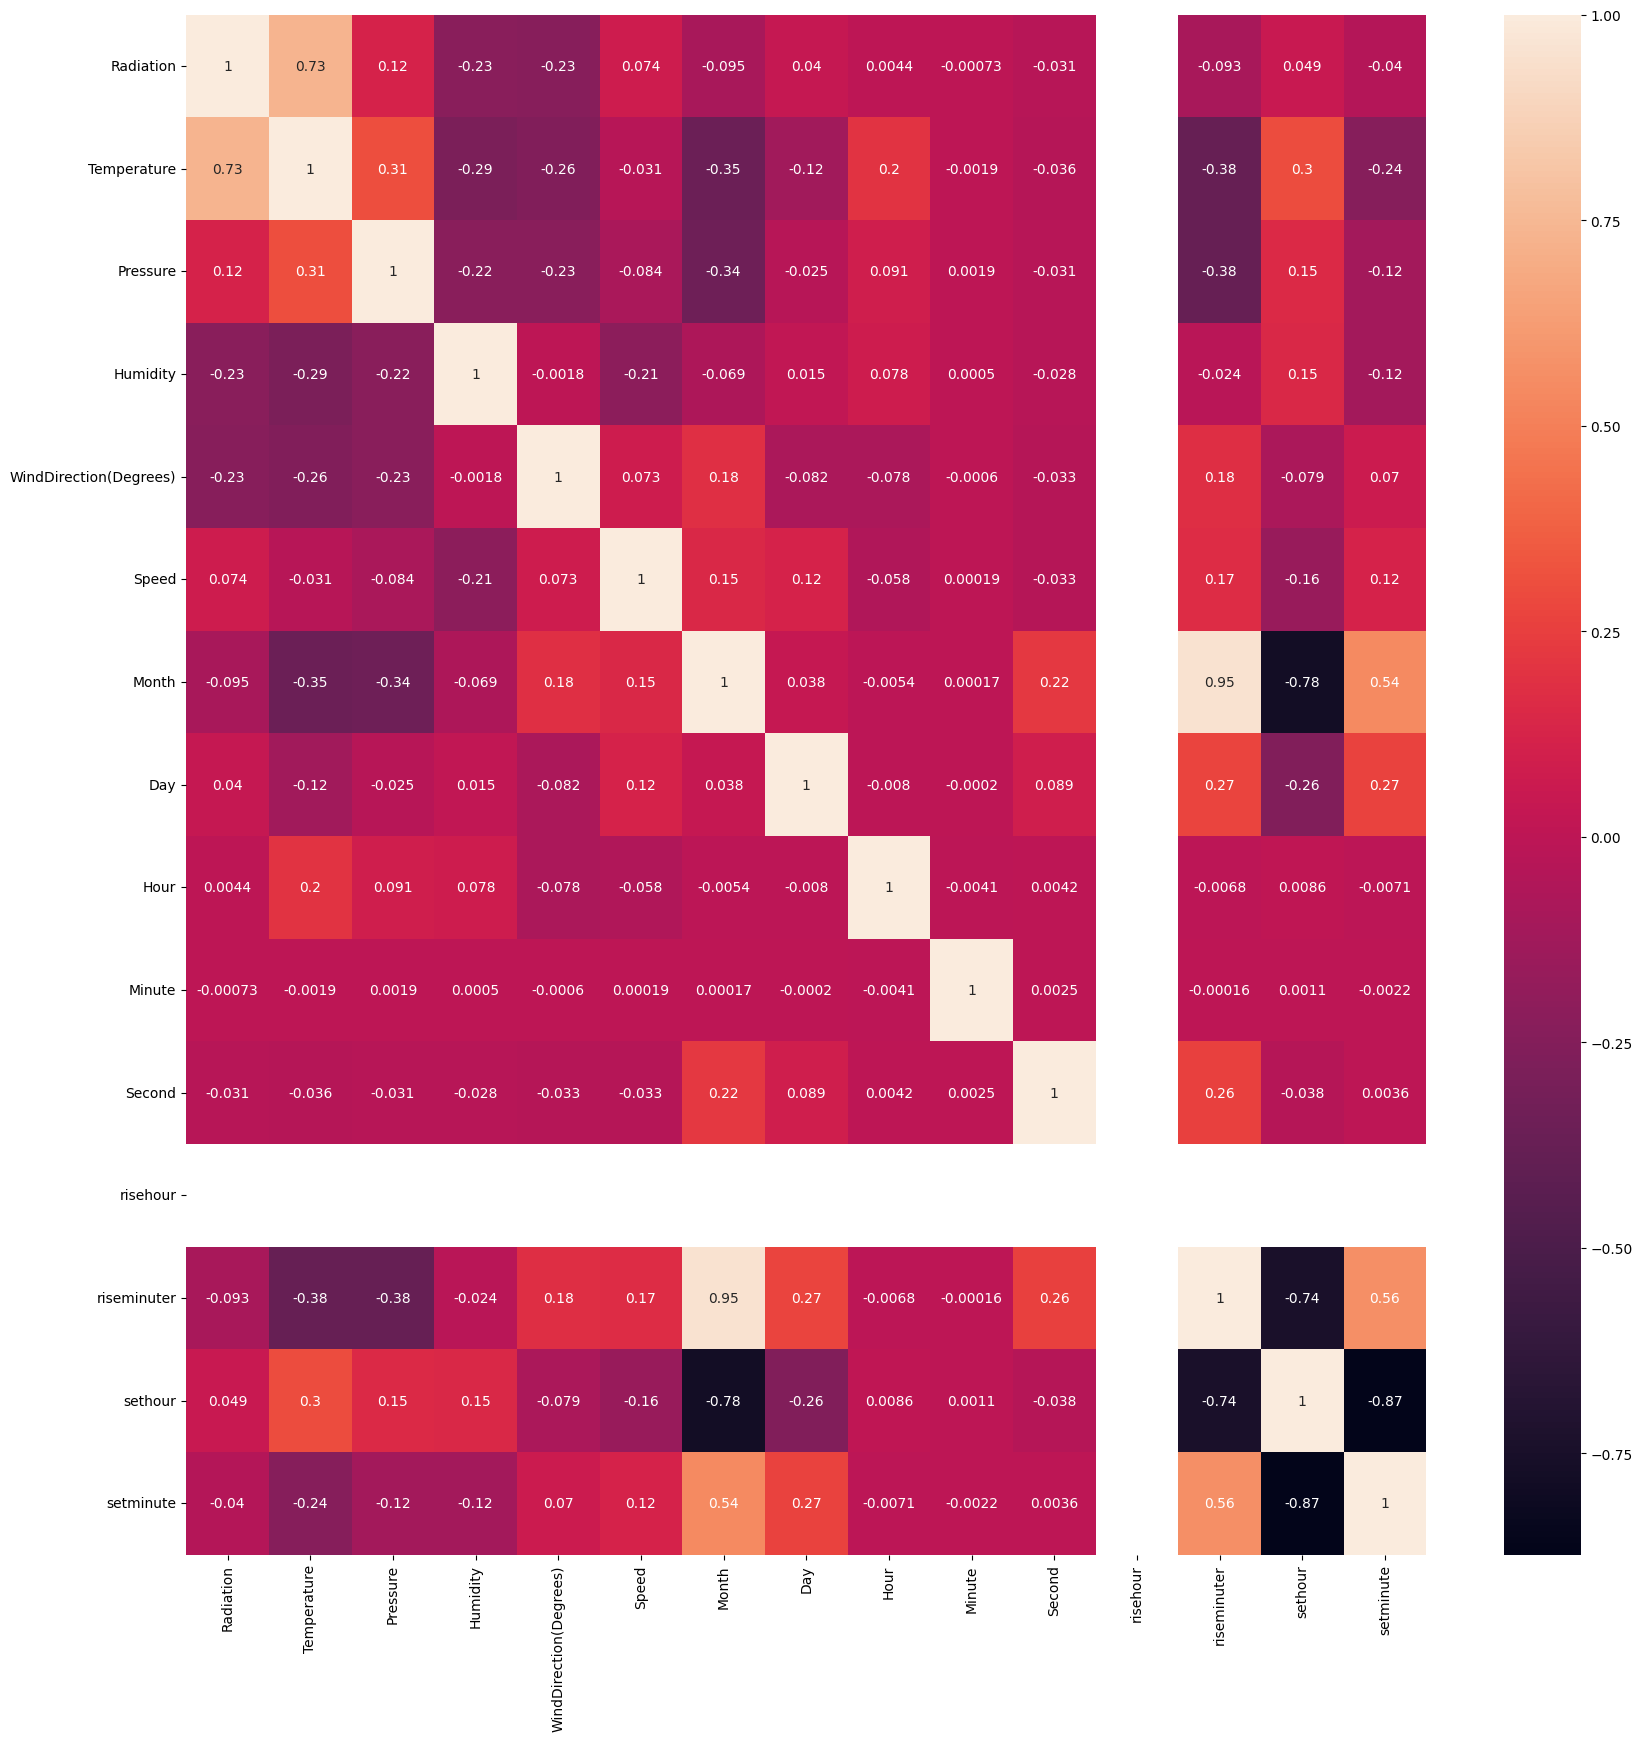

In [21]:
# plot the correlation matrix using heatmap for clear understanding
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), annot=True)
plt.show()

# Feature Selection using SelectBest Method

In [22]:
bestfeatures = SelectKBest(score_func = chi2, k = 10)

In [23]:
# use the label encoder
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
train_Y = label_encoder.fit_transform(target)

In [24]:
target_cont = df['Radiation'].apply(lambda x : int(x*100))
scaled_input_features = MinMaxScaler().fit_transform(input_features)
fit = bestfeatures.fit(scaled_input_features, target_cont)

In [25]:
scores = pd.DataFrame(fit.scores_)
column = pd.DataFrame(input_features.columns)

In [26]:
# contatinating data_features with the scores
featureScores = pd.concat([column, scores], axis=1)

#naming the dataframe columns
featureScores.columns = ['Features', 'feature_imp']

In [27]:
# best features
featureScores.sort_values(by = 'feature_imp', ascending=False, inplace=True)
featureScores

,Features,feature_imp
12,sethour,12207.531454
5,Month,4684.579610
11,riseminuter,4015.062771
3,WindDirection(Degrees),3271.827277
6,Day,2841.926850
8,Minute,2702.449333
9,Second,2288.673032
13,setminute,1863.712087
0,Temperature,1651.685632
2,Humidity,1588.087433


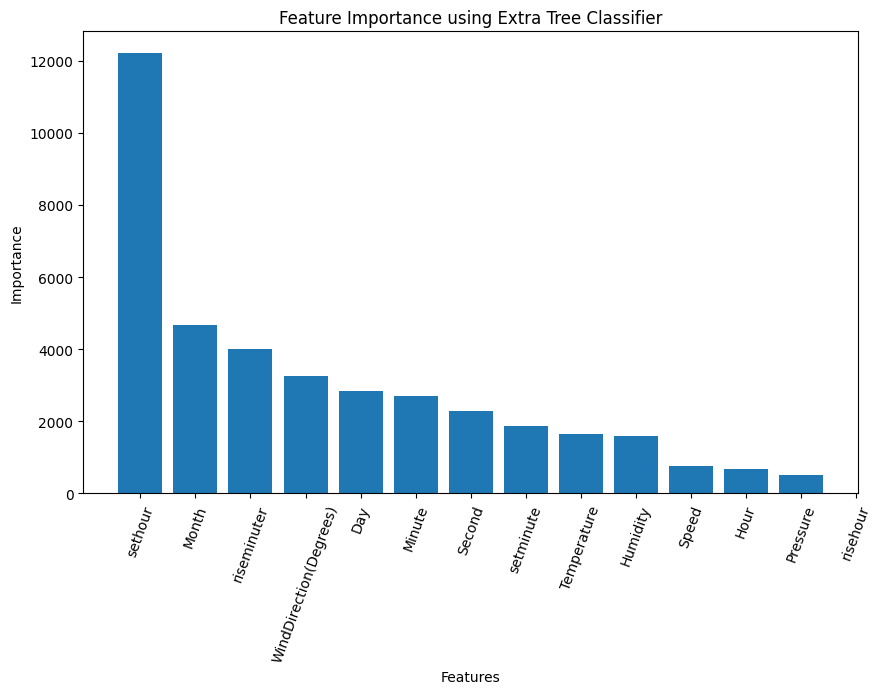

In [28]:
# visualise the feature importance
plt.figure(figsize = (10, 6))
plt.bar(featureScores.Features, featureScores.feature_imp)
plt.xticks(rotation = 70)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance using Extra Tree Classifier")
plt.show()